In [89]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")

In [3]:
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'

In [4]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [5]:
psi = 0

In [6]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [7]:
dx = 7.5 
dy = 7.5
dt = 1

In [8]:
depth, rows, cols = eta.shape
gridX, gridY = np.meshgrid(np.arange(1, cols+1), np.arange(1, rows+1))

# Centering and scaling
gridX = (gridX - np.mean(gridX)) * dx
gridY = (gridY - np.mean(gridY)) * dy

# ?? dont really know why youve to rescale the meshgrid of x and y

In [9]:
gridX

array([[-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       ...,
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5]])

In [10]:
gridY

array([[-247.5, -247.5, -247.5, ..., -247.5, -247.5, -247.5],
       [-240. , -240. , -240. , ..., -240. , -240. , -240. ],
       [-232.5, -232.5, -232.5, ..., -232.5, -232.5, -232.5],
       ...,
       [ 232.5,  232.5,  232.5, ...,  232.5,  232.5,  232.5],
       [ 240. ,  240. ,  240. , ...,  240. ,  240. ,  240. ],
       [ 247.5,  247.5,  247.5, ...,  247.5,  247.5,  247.5]])

In [11]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

In [12]:
dk

0.012503851357571316

In [13]:
wavenumbers = np.arange(3 * dk, 0.305, dk)
wavenumbers

# ?? dont know why the wavenumbers are like this 
# ?? can they be changed 

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [14]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1.0, 1.0]
# Ux current limits [m/s]

Uy_limits = [-1.0, 1.0]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

omegaWidthFun = lambda k: 0.05 + 0.0 * k

In [15]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [16]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [17]:
Uxm

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
       [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e

In [18]:
Uym

array([[-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e

# Define Functions

In [19]:
eta.shape

(1200, 67, 67)

In [20]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum

## retrieve_power_spectrum

In [21]:
Nt, Nx, Ny = eta.shape

In [22]:
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)

In [23]:
Kx

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [24]:
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

In [25]:
Ky

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [26]:
len(w)

1200

In [27]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [367]:
for jj in range(len(wavenumbers)):
    wavenumberLimits = wavenumbers[jj] + kW * np.array([-1, 1])

In [371]:
wavenumberLimits = wavenumbers[4] + kW * np.array([-1, 1])

In [430]:
wavenumbers[4]

0.08752695950299921

In [372]:
wavenumberLimits

array([0.07502311, 0.10003081])

In [373]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [374]:
Spectrum = retrieve_power_spectrum(eta, dx, dy, dt, K_limits = wavenumberLimits, W_limits = frequencyLimits)

In [375]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [376]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [377]:
wavenumberLimits[1]

0.10003081086057053

In [378]:
ind_x = np.abs(Kx) <= wavenumberLimits[1]
ind_y = np.abs(Ky) <= wavenumberLimits[1]
ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])

In [379]:
ind_x

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [380]:
ind_y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [381]:
ind_w

array([False, False, False, ...,  True,  True,  True])

In [382]:
Kx[ind_x]

array([-0.08885313, -0.07615982, -0.06346652, -0.05077321, -0.03807991,
       -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,  0.02538661,
        0.03807991,  0.05077321,  0.06346652,  0.07615982,  0.08885313])

In [383]:
# Create 3D structure using meshgrid
W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

In [384]:
Kx_3D.shape

(598, 15, 15)

In [385]:
Ky_3D.shape

(598, 15, 15)

In [386]:
W_3D.shape

(598, 15, 15)

In [387]:
W_3D[0,:,:].shape

(15, 15)

In [388]:
W_3D[:,:,0]

array([[0.01047198, 0.01047198, 0.01047198, ..., 0.01047198, 0.01047198,
        0.01047198],
       [0.01570796, 0.01570796, 0.01570796, ..., 0.01570796, 0.01570796,
        0.01570796],
       [0.02094395, 0.02094395, 0.02094395, ..., 0.02094395, 0.02094395,
        0.02094395],
       ...,
       [3.12588469, 3.12588469, 3.12588469, ..., 3.12588469, 3.12588469,
        3.12588469],
       [3.13112068, 3.13112068, 3.13112068, ..., 3.13112068, 3.13112068,
        3.13112068],
       [3.13635667, 3.13635667, 3.13635667, ..., 3.13635667, 3.13635667,
        3.13635667]])

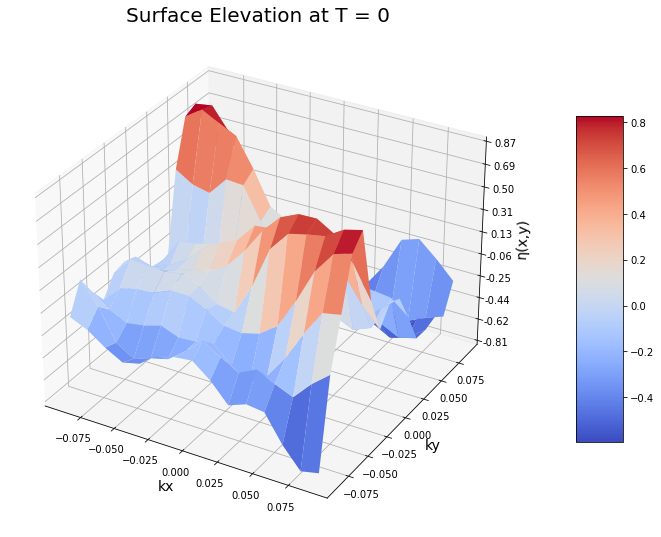

In [389]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Kx_3D[0,:,:], Ky_3D[0,:,:], eta[np.ix_(ind_w, ind_x, ind_y)][0,:,:], cmap=cm.coolwarm)

ax.set_xlabel('kx',fontsize=14)
ax.set_ylabel('ky',fontsize=14)
ax.set_zlabel('η(x,y)',fontsize=14)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=7, location = 'right', pad = 0.1)

plt.title('Surface Elevation at T = 0', fontsize=20)

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15, 15) and arg 2 with shape (49, 49).

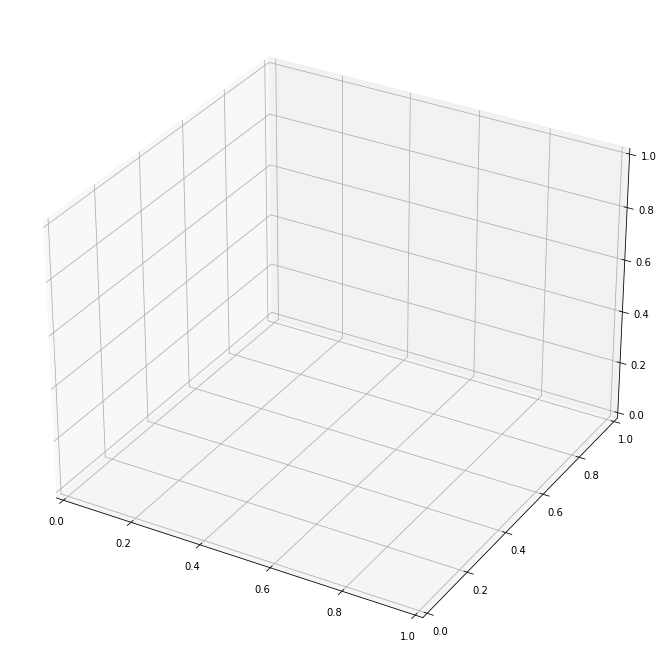

In [432]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Kx_3D[40,:,:], Ky_3D[40,:,:], power_Spectrum_cut[40,:,:], cmap=cm.coolwarm)

ax.set_xlabel('kx',fontsize=14)
ax.set_ylabel('ky',fontsize=14)
ax.set_zlabel('η(x,y)',fontsize=14)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=7, location = 'right', pad = 0.1)

plt.title('Power Spectral Density at T = 0', fontsize=20)

plt.show()

In [ ]:
plt.contourf(Kx_3D[0,:,:], Ky_3D[0,:,:], power_Spectrum_cut[0,:,:], cmap='viridis')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of Spectral Desnity at T = 0")

plt.colorbar()

In [391]:
# Set to NaN values outside K_limits
K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < wavenumberLimits[0]) | (K_3D > wavenumberLimits[1])] = np.nan

IndexError: boolean index did not match indexed array along dimension 1; dimension is 49 but corresponding boolean dimension is 15

In [392]:
wavenumberLimits

array([0.07502311, 0.10003081])

In [393]:
K_3D

array([[[0.1256573 , 0.11702648, 0.10919193, ..., 0.10919193,
         0.11702648, 0.1256573 ],
        [0.11702648, 0.10770625, 0.09913787, ..., 0.09913787,
         0.10770625, 0.11702648],
        [0.10919193, 0.09913787, 0.08975521, ..., 0.08975521,
         0.09913787, 0.10919193],
        ...,
        [0.10919193, 0.09913787, 0.08975521, ..., 0.08975521,
         0.09913787, 0.10919193],
        [0.11702648, 0.10770625, 0.09913787, ..., 0.09913787,
         0.10770625, 0.11702648],
        [0.1256573 , 0.11702648, 0.10919193, ..., 0.10919193,
         0.11702648, 0.1256573 ]],

       [[0.1256573 , 0.11702648, 0.10919193, ..., 0.10919193,
         0.11702648, 0.1256573 ],
        [0.11702648, 0.10770625, 0.09913787, ..., 0.09913787,
         0.10770625, 0.11702648],
        [0.10919193, 0.09913787, 0.08975521, ..., 0.08975521,
         0.09913787, 0.10919193],
        ...,
        [0.10919193, 0.09913787, 0.08975521, ..., 0.08975521,
         0.09913787, 0.10919193],
        [0.1

In [394]:
# Get original spectrum limits
Kx_orig_limits = [Kx[0], Kx[-1]]
Ky_orig_limits = [Ky[0], Ky[-1]]
W_orig_limits = [w[0], w[-1]]

In [395]:
power_Spectrum_cut.shape

(598, 49, 49)

In [396]:
np.nanmax(power_Spectrum_cut)

0.006304515130033762

In [397]:
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [398]:
np.nanmax(power_Spectrum_cut)

0.006304515130033763

In [399]:
power_Spectrum_cut

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

## get_doppler_shift_velocities_nsp

In [400]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    if not verboseFig:
        verboseFig = 0

    if 'include2ndHarmonic' not in fit_param:
        fit_param['include2ndHarmonic'] = 0

    if 'logFlag' not in fit_param:
        fit_param['logFlag'] = 0

    if 'SNR_filter' not in fit_param:
        fit_param['SNR_filter'] = 0

    if 'SNR_threshold' not in fit_param:
        fit_param['SNR_threshold'] = 2.0

    if 'Peak_filter' not in fit_param:
        fit_param['Peak_filter'] = 0

    if 'Peak_threshold' not in fit_param:
        fit_param['Peak_threshold'] = 0.5

    if 'Outlier_filter' not in fit_param:
        fit_param['Outlier_filter'] = 0

    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    if fit_param['SNR_filter']:
        SNR_inds = out_fit['SNR_max'] > fit_param['SNR_threshold']
        out_fit['Ux_filt'][~SNR_inds] = np.nan
        out_fit['Uy_filt'][~SNR_inds] = np.nan

    if fit_param['Peak_filter']:
        indsMultPeaks = peak_filter(out_fit['verbose'], fit_param['Peak_threshold'])
        out_fit['Ux_filt'][indsMultPeaks] = np.nan
        out_fit['Uy_filt'][indsMultPeaks] = np.nan

    if fit_param['Outlier_filter']:
        indsX_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Ux_filt'])
        indsY_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Uy_filt'])
        out_fit['Ux_filt'][~indsX_keep] = np.nan
        out_fit['Uy_filt'][~indsY_keep] = np.nan

    return out_fit


# Peak filter. Returns indices where there are multiple peaks in the SNR_2D field exceeding a threshold value.
def peak_filter(S, peak_thresh):
    inds_multiple_peaks = np.zeros(len(S), dtype=bool)

    for i in range(len(S)):
        peak_vals = S[i]['SNR_2D'][S[i]['Peaks_2D']]
        inds_multiple_peaks[i] = np.sum(peak_vals / np.max(peak_vals) > peak_thresh) > 1

    return inds_multiple_peaks


# Filter based on quartiles
def quartile_filter(x, y):
    inds_nan = np.isnan(y)

    x = x[~inds_nan]
    y = y[~inds_nan]

    pct = np.polyfit(x, y, 1)
    delCtil = y - np.polyval(pct, x)
    delCtil_srt = np.sort(delCtil)

    Q1 = np.median(delCtil_srt[:round(len(delCtil_srt) / 2)])
    Q3 = np.median(delCtil_srt[round(len(delCtil_srt) / 2):])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    inds_keep = np.logical_and(delCtil > lower_fence, delCtil < upper_fence)

    inds_outlier = np.ones(inds_nan.shape, dtype=bool)
    inds_outlier[~inds_nan] = inds_keep

    return inds_outlier

In [401]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    
    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers)}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    return out_fit



In [402]:
Ux_2D = Uxm
Uy_2D = Uym

In [403]:
Ux_2D

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
       [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e

In [404]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [405]:
Ux = np.zeros(len(wavenumbers))
Uy = np.zeros(len(wavenumbers))

In [406]:
Ux

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [407]:
SNR_max = np.zeros(len(wavenumbers))

In [408]:
omegaWidthFun
# just equals 0.05

<function __main__.<lambda>(k)>

In [409]:
omegaWidthFun(wavenumbers)

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [410]:
snrG = np.zeros(Ux_2D.shape)

In [411]:
snrG.shape

(21, 21)

In [412]:
fit_param = {'wavenumbers': 0.3000924325817116,
 'include2ndHarmonic': 0,
 'logFlag': [],
 'SNR_filter': 0,
 'SNR_threshold': 1.0,
 'Peak_filter': 0,
 'Peak_threshold': 0.5,
 'Outlier_filter': 0,
 'kWidth': 0.050015405430285265,
 'Ux_2D': np.array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
        [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01],
        [-7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01],
        [-6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01],
        [-5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01],
        [-4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01],
        [-3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01],
        [-2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01],
        [-1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01],
        [-2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16],
        [ 1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01],
        [ 2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01],
        [ 3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01],
        [ 4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01],
        [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01],
        [ 6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01],
        [ 7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01],
        [ 8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01],
        [ 9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 'Uy_2D': np.array([[-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00]])}

In [413]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [414]:
P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}

In [415]:
snrG = np.zeros(fit_param['Ux_2D'].shape)

In [416]:
for i in range(fit_param['Ux_2D'].shape[0]):
    for j in range(fit_param['Ux_2D'].shape[1]):
        snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, max(wavenumbers), fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
        snrG[i, j] = snr_ij

In [417]:
snrG.shape

(21, 21)

In [418]:
im = np.argmax(snrG)
# gets the index of maximum value of when its a 1d array

In [419]:
im

136

In [420]:
if np.ndim(Ux_2D) == 1:
    cDoppGuess = Ux_2D[im]
else:
    Ux_1D = Ux_2D.flatten()
    Uy_1D = Uy_2D.flatten()
    cDoppGuess = [Ux_1D[im], Uy_1D[im]]

In [421]:
cDoppGuess

[-0.40000000000000013, -2.220446049250313e-16]

In [422]:
Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] 
                if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], 
                                                                        U[0], U[1])[0], cDoppGuess)

In [423]:
Ufit

      fun: -15.129425937199336
 hess_inv: array([[ 0.09238767, -0.00305422],
       [-0.00305422,  0.01397905]])
      jac: array([-1.66893005e-06,  3.33786011e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-0.36520079, -0.00519623])

In [424]:
if len(cDoppGuess) > 1:
    Ufit = Ufit.x
else:
    Ufit = [Ufit.x[0], 0]

In [425]:
Ufit

array([-0.36520079, -0.00519623])

In [426]:
Ux = Ufit[0]
Uy = Ufit[1]

In [427]:
Ux

-0.3652007913488268

In [428]:
Uy

-0.00519622778470467

In [429]:
## These are values for k = 0.3 ish 

## nsp_doppler_shift_extraction

In [302]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [303]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [304]:
U = Ux_2D[0,0]
V = Uy_2D[0,0]

In [305]:
omegaFun = lambda kx, ky: np.sqrt((g*np.sqrt(kx**2 + ky**2) + T*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * h))+ U*kx + V*ky


In [306]:
omegaFun

<function __main__.<lambda>(kx, ky)>

In [307]:
omegaWidth = omegaWidthFun(wavenumbers)

In [308]:
a = omegaWidth

In [292]:
kWidth = 0.050015405430285265

In [293]:
a_k = kWidth

In [294]:
inds = ~np.isnan(power_Spectrum_cut)

In [295]:
inds

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [296]:
P_k = np.sqrt(power_Spectrum_cut[inds])
KX = Kx_3D[inds]
KY = Ky_3D[inds]
W = W_3D[inds]

In [297]:
P_k

array([1.19843123e-04, 4.56556814e-05, 1.76405282e-05, ...,
       1.69691060e-05, 2.63387036e-05, 7.15650607e-05])

In [298]:
KX

array([-0.30463929, -0.30463929, -0.30463929, ...,  0.30463929,
        0.30463929,  0.30463929])

In [299]:
KY

array([-0.06346652, -0.05077321, -0.03807991, ...,  0.03807991,
        0.05077321,  0.06346652])

In [212]:
W

array([0.01047198, 0.01047198, 0.01047198, ..., 3.13635667, 3.13635667,
       3.13635667])

In [221]:
P_k2 = 0

In [216]:
K = np.sqrt(KX**2 + KY**2)
order = 2

In [220]:
K

array([0.31118016, 0.30884141, 0.30701006, ..., 0.30701006, 0.30884141,
       0.31118016])

In [224]:
a_k

0.050015405430285265

In [226]:
np.isnan(wavenumbers)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [227]:
P_k

array([1.19843123e-04, 4.56556814e-05, 1.76405282e-05, ...,
       1.69691060e-05, 2.63387036e-05, 7.15650607e-05])

In [228]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [230]:
a_k

0.050015405430285265

In [229]:
K

array([0.31118016, 0.30884141, 0.30701006, ..., 0.30701006, 0.30884141,
       0.31118016])

In [223]:
if not np.isnan(wavenumbers):
    P_k = P_k * np.exp(-2*((K-wavenumbers)/a_k)**order)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [255]:
# Define weighting function G
G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

G = G1 + G2

In [261]:
G

array([0., 0., 0., ..., 0., 0., 0.])

In [300]:
for i in range(Ux_2D.shape[0]):
    for j in range((Ux_2D.shape[1])):
        omegaFun = lambda kx, ky: np.sqrt((g*np.sqrt(kx**2 + ky**2) + 
                                           T*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * h))+ Ux_2D[i,j]*kx + Uy_2D[i,j]*ky
        
        inds = ~np.isnan(power_Spectrum_cut)
        
        P_k = np.sqrt(power_Spectrum_cut[inds])
        KX = Kx_3D[inds]
        KY = Ky_3D[inds]
        W = W_3D[inds]
        
        # Define weighting function G
        G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
        G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

        G = G1 + G2
        

KeyboardInterrupt: 

In [112]:
eta[np.ix_(ind_w, ind_x, ind_y)].shape

(598, 49, 49)

In [107]:
power_Spectrum_cut[0,:,:].shape

(49, 49)

In [75]:
# Use np.ix_ for boolean indexing to extract the desired values
power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

In [78]:
power_Spectrum_cut

array([[[0.01967799, 0.03194935, 0.03575297, ..., 0.07631303,
         0.01295038, 0.03949204],
        [0.01294733, 0.02011113, 0.03958926, ..., 0.08064415,
         0.01814237, 0.0138356 ],
        [0.03996582, 0.0277632 , 0.07093516, ..., 0.07614884,
         0.02929407, 0.00140599],
        ...,
        [0.00131242, 0.02913716, 0.07544416, ..., 0.07214952,
         0.02824071, 0.04042018],
        [0.01372955, 0.0178005 , 0.07940581, ..., 0.03995812,
         0.02026839, 0.01337211],
        [0.03937987, 0.01300288, 0.07580499, ..., 0.036466  ,
         0.03258221, 0.02009286]],

       [[0.01957106, 0.03178926, 0.03558155, ..., 0.07645182,
         0.01294114, 0.0395249 ],
        [0.0128425 , 0.02007432, 0.0395066 , ..., 0.08095245,
         0.01823162, 0.01386514],
        [0.03985736, 0.02765655, 0.07062534, ..., 0.07634091,
         0.02934843, 0.00142935],
        ...,
        [0.00129023, 0.02909447, 0.07526903, ..., 0.07246404,
         0.02836841, 0.04053605],
        [0.0

In [64]:
frequencyLimits

[0.01, 20.0]

# Triplet Method

In [32]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [33]:
spec3d

In [34]:
spec3d.get_C()

(array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
         3.13112068,  3.13635667]),
 array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
        -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
        -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
        -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
        -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
        -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
        -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
         0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
         0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
         0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
         0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
         0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
         0.3427192 ,  0

In [35]:
w = spec3d.get_C()[0]

In [36]:
Kx = spec3d.get_C()[1]

In [37]:
Ky = spec3d.get_C()[2]

In [38]:
Ky

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [39]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [40]:
dKx

0.012693303650867849

In [41]:
dKy

0.012693303650867849

In [42]:
dW

0.005235987755983107

In [43]:
Norm = dKx * dKy * dW

In [44]:
Norm

8.436221250974528e-07

In [45]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [46]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [51]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [165]:
Norm

8.436221250974528e-07

In [166]:
dKx*dKy*dW

8.436221250974528e-07

In [144]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [145]:
np.sqrt ( spec3d.spectrum() ) * Norm * np.prod(eta.shape) 

array([[[4.08606173e-05, 4.07594049e-05, 4.04517985e-05, ...,
         3.98564894e-05, 4.04517985e-05, 4.07594049e-05],
        [4.13086372e-05, 4.16586780e-05, 4.17852395e-05, ...,
         3.86535405e-05, 3.98570436e-05, 4.07110299e-05],
        [4.26480896e-05, 4.34743033e-05, 4.41186491e-05, ...,
         3.82774701e-05, 4.02475014e-05, 4.16143729e-05],
        ...,
        [4.50953527e-05, 4.35262423e-05, 4.16079049e-05, ...,
         4.87923908e-05, 4.75512255e-05, 4.63726514e-05],
        [4.26480896e-05, 4.16143729e-05, 4.02475014e-05, ...,
         4.47697160e-05, 4.41186491e-05, 4.34743033e-05],
        [4.13086372e-05, 4.07110299e-05, 3.98570436e-05, ...,
         4.18361197e-05, 4.17852395e-05, 4.16586780e-05]],

       [[4.08609775e-05, 4.07377871e-05, 4.03898026e-05, ...,
         3.98798297e-05, 4.04456717e-05, 4.07523879e-05],
        [4.12877311e-05, 4.16485003e-05, 4.18509244e-05, ...,
         3.87293700e-05, 3.99127150e-05, 4.07479428e-05],
        [4.26828713e-05, 